# AIQDSC28 - Introduction to Deep Learning

**Student**: Quentin Le Roux

## Instructions

With the available part of the MIMICS dataset, **propose your two best models** to predict:

> **the number of days to next re-hospitalization** (assessment metrics, MSE on predicted number of days)

To build the first model, you can use all or part of the following columns, and of course do all the preprocessing you want:

- **DOB**: Date of Birth
- **GENDER**
- **MARITAL_STATUS**
- **ETHNICITY**
- **INSURANCE**
- **DEATHTIME**: Date of Death (if the patient has died)
- **ADMITTIME**: Date of the admission
- **ADMISSION_TYPE**
    - blood, circulatory, congenital, digestive, endocrine, genitourinary, infectious, injury, mental, misc, muscular, neoplasms, nervous, pregnancy, prenatal, respiratory, skin
    - Bag of Words representation of diagnosis
- **DISCHTIME**: date of the discharge
- **DISCHARGE_LOCATION**: patient's destination after discharge from hospital
- **TEXT**: discharge medical report

To build the second model, you will add the column TEXT (discharge medical report).

To build Y, you can use all or part of the following columns (and there too, do the preprocessing you want):

- **DAYS_NEXT_ADMIT**: number of days between discharge and readmission
- **NXT_ADMITTIME**: date of readmission
- **OUTPUT_LABEL**
- **DEATHTIME**: Date of Death (if the patient has died)

**Data leakage** (i.e. https://www.kaggle.com/alexisbcook/data-leakage) has to be accounted for/dealt with.

The rendering will be in the form of a **jupyter notebook written like a report**: with a clearly announced plan, different sections and a conclusion.

*A part of the grade will be given on the quality of the report (8 points), a part on the quality of the work done, and the respect of the methodology (6 points), a part on the quality of the prediction (6 points)*. 

### <span style="color:red">Note on Data Leakage</span> (excerpts from [Kaggle](https://www.kaggle.com/alexisbcook/data-leakage))

> "Data leakage (or leakage) happens when **your training data contains information about the target**, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.
> 
> [...]
> 
> **Target leakage** occurs when your predictors include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the timing or chronological order that data becomes available, not merely whether a feature helps make good predictions.
> 
> [...] 
> 
> Validation is meant to be a measure of how the model does on data that it hasn't considered before. You can corrupt this process in subtle ways if the validation data affects the preprocessing behavior. This is sometimes called **train-test contamination**."

## 0. Table of Content

1. **Introduction**

    a. Overview of project steps
    
    b. Library imports and built functions


2. **Pre-processing**

    a. Overview of pre-processing steps
    
    b. Data pre-processing
   
   
3. **Modeling without the TEXT variable**
 
 
4. **Modeling with the TEXT variable**


5. **Conclusion**

## 1. Introduction

### 1.1 Overview of project steps
    
The project will proceed using the following steps:

1. **Pre-processing of the dataset** (building a train and test set of features)

> We end up with a training and testing set containing 842 features (incl. 819 bag-of-words embedding of the DIAGNOSIS table)

> <span style="color:red">TEXT XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX</span>

2. **Training and testing our models**


3. **Selecting the most promising** of the four and **perform further hyperparameter tuning, dataset refining, etc.** to increase the model's performance


4. Perform the same on our TEXT representation


5. **Concluding** and propose further areas of exploration


### 1.2 Library imports and built functions

In [1]:
# Library imports

import datetime as dt
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

from itertools import cycle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function Declarations

def remove_stop_words(tokenized_sentence):
    """
    Removes the stop words from a tokenized sentence
    """
    punctuation = [".", ",", "[", "]", "`", "(", ")", 
                   "?", "'", "'s", ":", "!"]
    stop_words = stopwords.words('english')
    stop_words += punctuation
    return [w for w in tokenized_sentence if w not in stop_words]
    
def lemmatize(tokenized_sentence):
    """
    Create a lemmatizer object and lematized tokenized items 
    (e.g. sentences). Might require running the following:
        nltk.download('wordnet')
    """
    lemmatizer = nltk.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokenized_sentence]

sentence_processing = lambda sentence: " ".join(
    lemmatize(
        remove_stop_words(
            word_tokenize(str.lower(str(sentence)))
        )
    )
)
    
def regression_score(pred_train, pred_test, y_train, y_test):
    """
    Prints the MSE and R^2 of a regression model
    """
    mse_train = mean_squared_error(y_train, pred_train)
    mse_test = mean_squared_error(y_test, pred_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    print("--- Train Set Scores ---")
    print('Mean squared error: %.2f' % mse_train)
    print('Coefficient of determination: %.2f'% r2_train)
    print("\n--- Test Set Scores ---")
    print('Mean squared error: %.2f' % mse_test)
    print('Coefficient of determination: %.2f'% r2_test)
    return mse_train, mse_test, r2_train, r2_test

## 2. Pre-processing

### 2.1 Overview of pre-processing steps
    
- Loading the training and testing sets


- Providing preliminary notes on the training and testing sets


- Identifying columns/features with a risk of data leakage

    - issues related to mismatching "entries for one patient" in the dataset
    
    - Data leakage about a potential target variable in some columns


- Selecting the feature variables (X)

    - Discarding columns due to data leakage
    
    - Selecting model features
    

- Building/Wrangling the features variables

    - Dealing with NaN values
    
    - Building a LENGTH_OF_STAY feature
    
    - Building an AGE feature
    
    - One-hot encoding the kept discrete features (GENDER, MARITAL_STATUS, ETHNICITY, INSURANCE, ADMISSION_TYPE)
    
    - Building a word embedding of the DIAGNOSIS column
    
    - Building the final training and testing datasets


- Building the target variable(s) (Y)

    - Building a Regression target variable
    
    - Building a Classification target variable



### 2.2 Data Pre-processing

#### 1 - <u>Loading the *training* and *testing* sets:</u>

We load the dataset and also create placeholder variables. These will hold the processed training and testing data so that we do not erase the original data.

In [3]:
online_path = "http://www.i3s.unice.fr/~riveill/dataset/MIMIC-III-readmission/"
train_set_path = online_path + "train.csv.zip"
test_set_path = online_path + "test.csv.zip"

local_train_set_path = "./datasets/train.csv.zip"
local_test_set_path = "./datasets/test.csv.zip"

In [4]:
# df_train = pd.read_csv(train_set_path)
# df_train = pd.read_csv(test_set_path)

df_train = pd.read_csv(local_train_set_path)
df_test = pd.read_csv(local_test_set_path)

In [5]:
X_train = None
X_test = None

In [6]:
y_train = None
y_test = None

#### 2 - <u>Providing preliminary notes on the training and testing sets:</u>

- We find that the training dataset holds **2000 entries**, while the testing dataset holds **901 entries**, i.e., a **69 to 31 train-test ratio**. 

> A small dataset usually implies the following rule of thumb with regards to training: When a dataset is small a ratio of 80 to 20 train-test split is preferable. As such, the current split is okay as-is.


- There seems to be **several features with NaN values**. We will have to decide what to do with them.


- The available features are of types **int64** or **Object**. We will have to modify the types of those variables accordingly.


- As seen in the [MIMIC-III Clinical Database Demo 1.4](https://physionet.org/content/mimiciii-demo/1.4/ADMISSIONS.csv), the DIAGNOSIS variable corresponds to a string value containing a list of diagnoses separated by specific characters (e.g. ' **/** ', ' **;** ', ' **,** ', ' **-** ', etc.). 

> A bag of words representation of DIAGNOSIS is provided in the dataset. Given that we see more than 0 or 1 values (i.e. binary values), we can infer that the provided BoW approach may represent some kind of importance associated with each word (e.g. number of time the term appears).

**Given the lack of information on the way the BoW was created, we might want to create our own word embedding representation**.
    
<u>Preliminary information on the sets:</u>

In [7]:
df_train.describe()

,SUBJECT_ID,HADM_ID,DAYS_NEXT_ADMIT,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
count,2000.000000,2000.000000,1210.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0000
mean,18155.690500,150103.483000,119.883433,0.482500,2.858000,0.036000,0.747500,1.389000,0.660500,0.438500,...,0.447500,0.430500,0.216000,0.255500,0.421000,0.008000,0.119000,0.972500,0.189000,0.5050
std,26240.378348,29205.036893,404.753993,0.735503,2.253969,0.196783,1.179593,1.329121,0.895902,0.809658,...,0.847114,0.739894,0.544511,0.704605,0.801299,0.151484,0.376709,1.199359,0.551753,0.5001
min,11.000000,100095.000000,-0.602083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
25%,1490.500000,124979.500000,5.383333,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
50%,3103.500000,150743.500000,13.219792,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0000
75%,25072.750000,174570.750000,25.327951,1.000000,4.000000,0.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.0000
max,99562.000000,199955.000000,3867.977778,5.000000,13.000000,2.000000,9.000000,10.000000,4.000000,7.000000,...,9.000000,5.000000,5.000000,8.000000,7.000000,4.000000,5.000000,6.000000,6.000000,1.0000


In [8]:
df_test.describe()

,SUBJECT_ID,HADM_ID,DAYS_NEXT_ADMIT,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
count,901.000000,901.000000,526.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,...,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000
mean,18306.197558,149172.830189,84.578517,0.466149,2.817980,0.044395,0.728080,1.372919,0.700333,0.468368,...,0.468368,0.436182,0.201998,0.243063,0.440622,0.015538,0.119867,0.931188,0.241953,0.503885
std,26349.689656,29115.501914,304.437951,0.691390,2.256878,0.231479,1.165418,1.406611,0.944628,0.804397,...,0.919147,0.752463,0.538760,0.682942,0.784625,0.253383,0.354423,1.184030,0.624726,0.500263
min,6.000000,100039.000000,-0.454167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1521.000000,123423.000000,5.100868,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3176.000000,147718.000000,11.302431,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,25256.000000,174749.000000,22.211632,1.000000,4.000000,0.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.000000
max,99982.000000,199807.000000,3543.101389,4.000000,12.000000,2.000000,7.000000,7.000000,5.000000,7.000000,...,6.000000,5.000000,5.000000,5.000000,4.000000,5.000000,3.000000,7.000000,6.000000,1.000000


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SUBJECT_ID          2000 non-null   int64  
 1   HADM_ID             2000 non-null   int64  
 2   ADMITTIME           2000 non-null   object 
 3   DISCHTIME           2000 non-null   object 
 4   DAYS_NEXT_ADMIT     1210 non-null   float64
 5   NEXT_ADMITTIME      1210 non-null   object 
 6   ADMISSION_TYPE      2000 non-null   object 
 7   DEATHTIME           158 non-null    object 
 8   DISCHARGE_LOCATION  2000 non-null   object 
 9   INSURANCE           2000 non-null   object 
 10  MARITAL_STATUS      1924 non-null   object 
 11  ETHNICITY           2000 non-null   object 
 12  DIAGNOSIS           1998 non-null   object 
 13  TEXT                1925 non-null   object 
 14  GENDER              2000 non-null   object 
 15  DOB                 2000 non-null   object 
 16  blood 

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SUBJECT_ID          901 non-null    int64  
 1   HADM_ID             901 non-null    int64  
 2   ADMITTIME           901 non-null    object 
 3   DISCHTIME           901 non-null    object 
 4   DAYS_NEXT_ADMIT     526 non-null    float64
 5   NEXT_ADMITTIME      526 non-null    object 
 6   ADMISSION_TYPE      901 non-null    object 
 7   DEATHTIME           58 non-null     object 
 8   DISCHARGE_LOCATION  901 non-null    object 
 9   INSURANCE           901 non-null    object 
 10  MARITAL_STATUS      861 non-null    object 
 11  ETHNICITY           901 non-null    object 
 12  DIAGNOSIS           901 non-null    object 
 13  TEXT                871 non-null    object 
 14  GENDER              901 non-null    object 
 15  DOB                 901 non-null    object 
 16  blood   

#### 3 - <u>Identifying columns/features with a risk of data leakage:</u>

> <span style="color:red">The following examples are interesting as they outline data leakage risk we want to contain or remove</span>.
>  
> Our goal is also individualizing each row so that we reduce the dependencies between each of them. Each datapoint should be independent between each other.

1. <u>issues related to mismatching "entries for one patient" in the dataset</u>

It is possible that a single patient (i.e. a single SUBJECT_ID) has multiple entries in the dataset.

> Based on the [information provided by the repository for the MIMIC dataset](https://mimic.physionet.org/mimictables/admissions/), HADM_ID represents a single patient’s admission(s) to the hospital and SUBJECT_ID represents a single patient.
>
> To avoid data leakage, we must identify features which we will need to exclude due to leakage.

<u>Example with SUBJECT_ID 17:</u>

In [11]:
# We look for the number of times a single patient has been admitted 
# to a hospital. 
# We find that a single patient may have been admitted up to 15 times 
# in the training set.

df_train.pivot_table(index = ['SUBJECT_ID'], aggfunc ='size').unique()

array([ 1,  2, 15,  3,  5,  4,  6,  8])

In [12]:
# We identify that patient 17 has been admitted twice.

print(df_train.pivot_table(index = ['SUBJECT_ID'], aggfunc ='size').head(2))
df_train[df_train["SUBJECT_ID"]==17]

SUBJECT_ID
11    1
17    2
dtype: int64


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,DISCHARGE_LOCATION,INSURANCE,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
1182,17,161087,2135-05-09 14:11:00,2135-05-13 14:40:00,NaN,NaN,EMERGENCY,NaN,HOME HEALTH CARE,Private,...,1,1,2,0,0,0,0,1,0,0
1710,17,194023,2134-12-27 07:15:00,2134-12-31 16:05:00,128.920833,2135-05-09 14:11:00,ELECTIVE,NaN,HOME HEALTH CARE,Private,...,0,0,0,0,0,0,0,0,0,0


We want to check if patients have a number of rows equal to the number of admission mentioned in the data (i.e. 1 row = 1 admission). Based on the following data wrangling, it appears that:

- Some patients have a mismatched between the number of mentioned readmission dates and the number of lines associated to their case.

<u>Interpretation:</u> <span style="color:red">The dataset cannot be understood as a time series</span>. As such, each row (and their potential readmission) should be construed as independent from other rows. 

<u>Implication:</u> In terms of data leakage, it implies we should individualize each row in a way that no two rows can be linked to each other (independence).

<u>Example with SUBJECT_ID 937:</u>

In [13]:
# We find that patient 937 has been admitted twice but has only one 
# single record in the training dataset.

df_train[df_train["SUBJECT_ID"]==937]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,DISCHARGE_LOCATION,INSURANCE,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
0,937,148592,2163-01-20 18:39:00,2163-01-24 08:00:00,0.061806,2163-01-24 09:29:00,EMERGENCY,2163-01-26 08:00:00,DEAD/EXPIRED,Medicare,...,0,0,0,0,1,0,0,0,0,1


<u>Example with SUBJECT_ID 808:</u>

In [14]:
# We see that patient 808 has three referenced admissions but the last
# record mentions another admission that is not referenced in the set.

# The admit times are also mismatched. There are 3 admissions with 
# each showing a next admission time, implying at least one admission 
# is missing from the dataset.

df_train[df_train["SUBJECT_ID"]==808]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,DISCHARGE_LOCATION,INSURANCE,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
553,808,197130,2181-11-16 08:18:00,2181-11-23 09:04:00,8.701389,2181-12-02 01:54:00,EMERGENCY,NaN,HOME HEALTH CARE,Private,...,0,0,0,2,0,0,0,3,0,1
1189,808,100677,2181-07-12 20:11:00,2181-07-17 13:14:00,13.395833,2181-07-30 22:44:00,EMERGENCY,NaN,HOME HEALTH CARE,Private,...,0,1,0,3,0,0,0,0,0,1
1995,808,139077,2181-05-11 16:57:00,2181-05-16 11:58:00,13.701389,2181-05-30 04:48:00,EMERGENCY,NaN,HOME,Private,...,0,0,0,0,0,0,0,2,0,1


2. <u>Data leakage about a potential target variable in some columns</u> 
    
Some features leak information about a potential target variable.

We see that DISCHARGE_LOCATION and TEXT hold important data with regards to the outcome of the patient's stay.

<u>Example with SUBJECT_ID 937:</u>

> In the case of patient 937 (i.e. a 75-year-old man with a history of hypertension), we see that the person died during their care at the hospital and that the mention of their death (term used: dead/expired) is referenced in both columns.

In [15]:
# We find that the cell DISCHARGE_LOCATION holds important data on 
# the fate of patient 937.

df_train[df_train["SUBJECT_ID"]==937]["DISCHARGE_LOCATION"]

0    DEAD/EXPIRED
Name: DISCHARGE_LOCATION, dtype: object

In [16]:
# We find that the cell TEXT holds important data on the fate of 
# patient 937:
#     Discharge Disposition:\nExpired\n\nDischarge Diagnosis:\n1.  
#     intraparenchymal hemmorrhage\n\nDischarge Condition:\nexpired

print(df_train[df_train["SUBJECT_ID"]==937]["TEXT"].values)

['Admission Date:  [**2163-1-20**]              Discharge Date:   [**2163-1-24**]\n\nDate of Birth:  [**2087-9-24**]             Sex:   M\n\nService: NEUROLOGY\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 5868**]\nChief Complaint:\ntransfer from ICH with intra-parenchymal bleed\n\nMajor Surgical or Invasive Procedure:\nnone\n\nHistory of Present Illness:\nThe patient is a 75 year old man with a history of hypertension\nand high cholesterol, now presenting on transfer from an OSH\nwith\na large right intraparenchymal cerebral bleed.  As per his\nchart, he originally presented to the OSH with the complaint of\ninability to feel his right leg.  An angiogram of the leg\nuncovered a right femoral artery occlusion and he was given t-\nPA (iv).  The next morning, the patient developed a left\nhemiparesis with left facial droop and a right gaze preference.\nAn emergent CT scan of his brain showed multiple hemorrhages\nprimarily in the r

#### 4 - <u>Selecting the feature variables (X):</u>

1. <u>Discarding columns due to data leakage</u>

We decide due to data leakage concerns to not focus on the following variables:

- DEATHTIME, ADMITTIME, DISCHTIME: those are obvious data leakage risk as they give information on actual readmission rates
- TEXT, DISCHARGE_LOCATION: data leakage risk (see note)
- Bag of Words (of DIAGNOSIS): We discard the provided bag of words as we will be building our own embedding

2. <u>Selecting model features</u>

As such, we focus on the following features (X):

- Age (which we will have to construct out of DOB and ADMITTIME)
- GENDER
- MARITAL_STATUS
- ETHNICITY (<span style="color:red">see note</span>)
- INSURANCE
- ADMISSION_TYPE
- Length of stay (which we will have to construct out of DISCTIME and ADMITTIME)
- DIAGNOSIS (from which we will build our own bag of words representation)

<u><span style="color:red">Note on ETHNICITY</span>:</u>

> It is important to note that **ethnic/racial data is a controversial topic in AI**. The goal is to avoid racial profiling as well as racial discrimination. Especially in health. 
>
> It happens that systemic racism and poverty greatly affect minorities in the United States. We recall that the [MIMIC dataset is a relational database containing tables of data relating to patients who stayed within the intensive care units](https://mimic.physionet.org/gettingstarted/overview/) at [Beth Israel Deaconess Medical Center in Boston, MA, USA](https://en.wikipedia.org/wiki/Beth_Israel_Deaconess_Medical_Center). The hospital is a *private* teaching center attached to the Harvard Medical School. In Massachusetts, [poverty afflicts minorities about twice as much as white people](https://www.welfareinfo.org/poverty-rate/massachusetts/).
>
> As such, ethnicity may have a **strong impact** on both the quality of their care, their access to insurance, and in the end their potential rate of readmission, etc.
>
> consequently, <span style="color:red">we will need to see if ethnicity has a strong effect on our end result, and, if possible, whether we can do without it</span>.

<u><span style="color:red">Note on TEXT and DISCHARGE_LOCATION</span>:</u>

> As we saw in the cell above, TEXT and DISCHARGE_LOCATION may hold important information on the end fate of the patient, meaning we cannot include those features as **it would leak information with regards to the outcome we want to predict**.

In [17]:
# We store our target features (or the columns used to build our 
# feature, e.g., "Age" and "Length of Stay") in our placeholders.

kept_columns = ["DOB", "GENDER", "MARITAL_STATUS", "ETHNICITY", "INSURANCE", 
                "ADMISSION_TYPE", "DIAGNOSIS", "ADMITTIME", "DISCHTIME"]

X_train = df_train[kept_columns].copy()
X_test = df_test[kept_columns].copy()

In [18]:
X_train.head(1)

,DOB,GENDER,MARITAL_STATUS,ETHNICITY,INSURANCE,ADMISSION_TYPE,DIAGNOSIS,ADMITTIME,DISCHTIME
0,2087-09-24 00:00:00,M,NaN,OTHER/UNKNOWN,Medicare,EMERGENCY,INTRACRANIAL HEMORRHAGE,2163-01-20 18:39:00,2163-01-24 08:00:00


#### 5 - <u>Building the feature variables (X):</u>

1. <u>What about NaN values?</u>

> As we see in the first code cell below, NaN values are found only in the MARITAL_STATUS and DIAGNOSIS columns. Knowing we will perform One-Hot Encoding for the former and a Bag of Words Embedding for the latter, we can afford not removing those rows as they will be transformed into features.

In [19]:
# We find that only the columns MARITAL_STATUS and DIAGNOSIS have NaN values in both the training
# and testing dataset.

print(X_train.isnull().sum(),
      X_test.isnull().sum(),
      sep="\n\n")

DOB                0
GENDER             0
MARITAL_STATUS    76
ETHNICITY          0
INSURANCE          0
ADMISSION_TYPE     0
DIAGNOSIS          2
ADMITTIME          0
DISCHTIME          0
dtype: int64

DOB                0
GENDER             0
MARITAL_STATUS    40
ETHNICITY          0
INSURANCE          0
ADMISSION_TYPE     0
DIAGNOSIS          0
ADMITTIME          0
DISCHTIME          0
dtype: int64


2. <u>Building LENGTH_OF_STAY (in days)</u>

> We build our length of stay variable by taking the difference between ADMITTIME and DISCTIME (in days)

In [20]:
# LENGTH_OF_STAY

# 1. convert dates to datetime
# 2. calculate the float value timedelta (in days)
X_train["ADMITTIME"] = pd.to_datetime(X_train["ADMITTIME"])
X_train["DISCHTIME"] = pd.to_datetime(X_train["DISCHTIME"])
X_train["LENGTH_OF_STAY"] = X_train["DISCHTIME"] - X_train["ADMITTIME"]
X_train["LENGTH_OF_STAY"] = X_train["LENGTH_OF_STAY"].dt.total_seconds() / (24 * 60 * 60)

X_test["ADMITTIME"] = pd.to_datetime(X_test["ADMITTIME"])
X_test["DISCHTIME"] = pd.to_datetime(X_test["DISCHTIME"])
X_test["LENGTH_OF_STAY"] = X_test["DISCHTIME"] - X_test["ADMITTIME"]
X_test["LENGTH_OF_STAY"] = X_test["LENGTH_OF_STAY"].dt.total_seconds() / (24 * 60 * 60)

 # we drop columns as they are not useful anymore
X_train.drop(["DISCHTIME"], axis = 1, inplace = True)
X_test.drop(["DISCHTIME"], axis = 1, inplace = True)

3. <u>Building AGE (in year)</u>

> We build our age variable by taking the difference between ADMITTIME and DOB (in year)

We see that some ages are impossible (being well above the oldest recorded age for a human being), leading to think that the dataset has misrecorded values. **119 rows are impacted**.

The way to deal with those is to **replace these erroneous values with the average age of the rest of the dataset** (i.e. the mean of all ages that are not impossible).

In [21]:
# AGE

# 1. convert dates to year
# 2. calculate the float value timedelta (in year)
X_train["DOB"] = pd.to_datetime(X_train["DOB"]).dt.year
X_train["ADMITTIME"] = X_train["ADMITTIME"].dt.year
X_train["AGE"] = X_train["ADMITTIME"] - X_train["DOB"]

X_test["DOB"] = pd.to_datetime(X_test["DOB"]).dt.year
X_test["ADMITTIME"] = X_test["ADMITTIME"].dt.year
X_test["AGE"] = X_test["ADMITTIME"] - X_test["DOB"]

 # we drop columns as they are not useful anymore
X_train.drop(["ADMITTIME", "DOB"], axis = 1, inplace = True)
X_test.drop(["ADMITTIME", "DOB"], axis = 1, inplace = True)

In [22]:
# Some calculated ages are well above possible values.

print(sorted(X_train["AGE"].unique()),
      sorted(X_test["AGE"].unique()),
      sep="\n\n")

[0, 1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 300, 301, 302, 303, 305, 306, 307, 308, 310]

[0, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 300, 301, 302, 303, 305, 308]


In [23]:
# There are 119 age value above 122 (the oldest recorded age in 
# history in a human)

len(X_train[X_train["AGE"]>122])

119

In [24]:
# We calculate the average age of the rest of the train dataset
# We replace the wrong age value with the calculated average in 
# both the train and test dataset

average_age = X_train[X_train["AGE"]<=89]["AGE"].mean()
print(average_age)

X_train.loc[(X_train.AGE > 89), 'AGE'] = average_age
X_test.loc[(X_test.AGE > 89), 'AGE'] = average_age

62.22328548644338


4. <u>One-hot encoding the kept discrete features (GENDER, MARITAL_STATUS, ETHNICITY, INSURANCE, ADMISSION_TYPE)</u>

> We build one-hot encoding for those variables

In [25]:
# One-Hot encoding of the following columns:
# GENDER, MARITAL_STATUS, ETHNICITY, INSURANCE, ADMISSION_TYPE

dummy_list = ["GENDER", "MARITAL_STATUS", "ETHNICITY", "INSURANCE", "ADMISSION_TYPE"]

X_train = pd.get_dummies(X_train, columns = dummy_list)
X_test = pd.get_dummies(X_test, columns = dummy_list)

5. <u>Building a word embedding of the DIAGNOSIS column</u>

> We want to build our own Bag of Word representation using the sklearn CountVectorizer object

In [26]:
# DIAGNOSIS

# Pre-processing the content of the DIAGNOSIS column
X_train["DIAGNOSIS"] = X_train["DIAGNOSIS"].apply(sentence_processing)
X_test["DIAGNOSIS"] = X_test["DIAGNOSIS"].apply(sentence_processing)

In [27]:
# Applying CountVectorizer to the pre-processed DIAGNOSIS column

#      We declare and fit the CountVectorizer object
cv = CountVectorizer(analyzer="word", ngram_range=(1,1), stop_words="english")
cv.fit(X_train["DIAGNOSIS"].tolist())

#      We transform the diagnosis column using the count vectorizer
tf = lambda s: cv.transform([s]).todense().tolist()[0]
X_train["DIAGNOSIS"] = X_train["DIAGNOSIS"].apply(tf)
X_test["DIAGNOSIS"] = X_test["DIAGNOSIS"].apply(tf)

#      We expand the resulting feature matrix into individual columns
X_train[cv.get_feature_names()] = pd.DataFrame(X_train["DIAGNOSIS"].tolist(), 
                                               index= X_train.index)
X_test[cv.get_feature_names()] = pd.DataFrame(X_test["DIAGNOSIS"].tolist(), 
                                               index= X_test.index)

In [28]:
# We look at the first 100 elements of the feature_names list of the 
# Count Vectorizer object

print(f"Number of diagnosis features: {len(cv.get_feature_names())}.",
      cv.get_feature_names()[:100],
      sep="\n\n")

Number of diagnosis features: 819.

['1st', '21', '22', 'abcess', 'abd', 'abdcess', 'abdomal', 'abdomen', 'abdominal', 'ablation', 'abscess', 'abuse', 'accending', 'access', 'accident', 'account', 'achalasia', 'acidosis', 'acitic', 'acsites', 'acute', 'advancement', 'afib', 'aicd', 'air', 'airway', 'alcohol', 'als', 'altered', 'aml', 'anasarca', 'anemia', 'aneursym', 'aneurysm', 'angina', 'angio', 'angiogram', 'angioplasty', 'ankle', 'anomaly', 'anterior', 'antibiotic', 'anticholinergic', 'aorta', 'aortic', 'appendicitis', 'approach', 'ar', 'arachnoid', 'arch', 'arf', 'arrest', 'arterial', 'artery', 'ascending', 'ascites', 'aspiration', 'assault', 'asthma', 'asthmaticus', 'ataxia', 'atriacure', 'atrial', 'atrioventricular', 'attach', 'attack', 'aureus', 'av', 'avascular', 'avr', 'axillo', 'bacteremia', 'bacterial', 'benign', 'bental', 'bentall', 'benzodiazepine', 'bi', 'bifemoral', 'bilateral', 'bile', 'bili', 'biliary', 'biventricular', 'bladder', 'bled', 'bleed', 'bleeding', 'block',

6. <u>Building the final training and testing datasets</u>

In [29]:
# We drop the DIAGNOSIS column
X_train.drop(["DIAGNOSIS"], axis=1, inplace=True)
X_test.drop(["DIAGNOSIS"], axis=1, inplace=True)

In [30]:
X_train.head(1)

,LENGTH_OF_STAY,AGE,GENDER_F,GENDER_M,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,...,wbc,weakness,west,wide,withdrawal,withdrawl,work,worsening,wound,wrist
0,3.55625,76.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
X_test.head(1)

,LENGTH_OF_STAY,AGE,GENDER_F,GENDER_M,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,...,wbc,weakness,west,wide,withdrawal,withdrawl,work,worsening,wound,wrist
0,39.55,62.223285,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 6 - <u>Building the target variable (Y):</u>
    
We want to estimate the re-hospitalization rate of a patient. The question is then:

> how to represent re-hospitalization?

In the case of **Regression**, we can predict the number of days between discharge and readmission for a patient

> We can build this target variable by using the DAYS_NEXT_ADMIT column. The issue is about how to represent the absence of readmission (NaN in the dataset)
>
> <u>Assumptions:</u>
>
> 1. Since there is no 0-valued DAYS_NEXT_ADMIT item in the dataset, we decide to set NaN values in that column to 0

<u>Building our regression-style target variable</u>

In [32]:
# We record the DAYS_NEXT_ADMIT column

y_train = df_train["DAYS_NEXT_ADMIT"].copy()
y_test = df_test["DAYS_NEXT_ADMIT"].copy()

# We count the NaN values

print(y_train.isnull().sum(),
      y_test.isnull().sum(),
      sep="\n")

790
375


In [33]:
# Based on our regression assumption we set NaN values to 0

y_train[y_train.isnull()]=0
y_test[y_test.isnull()]=0

# We check the NaN values have been changed

print(y_train.isnull().sum(),
      y_test.isnull().sum(),
      sep="\n")

0
0


<AxesSubplot:ylabel='Frequency'>

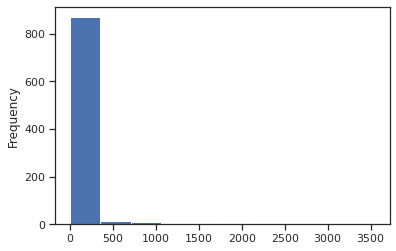

In [34]:
y_test.plot.hist()

## 3. Modeling without the TEXT variable

<u>Approach for Regression-style modeling:</u>

To evaluate our Linear Regression model, we will be using the Mean Squared Error and Coefficient of Determination $R^2$.

$${MSE} = \frac{1}{n}\overset{n}{\underset{i=1}{\sum}}(Y_i - \hat{Y}_i)^2$$

With $Y$ the vector of observed values of the variable being predicted, $\hat{Y}$ the predicted values.

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

with $SS_{tot}$, the total sum of squares (and $\bar{y} = \frac{1}{n}\overset{n}{\underset{i=1}{\sum}}Y_i$):

$$SS_{tot} = \overset{n}{\underset{i=1}{\sum}}(Y_i - \bar{Y})$$

And with $SS_{res}$, the sum of squares of residuals, i.e., $MSE$.

### 3.1 Model 1

In [35]:
# Model declaration and training


In [36]:
# Model prediction


In [37]:
# Scores


### 3.XXXXXXXXXXXXXXXXXX Observations

<span style="color:green">qqqqq.</span>

## 4. Modeling with the TEXT variable


### 4.1 Model 1

In [38]:
# Model declaration and training


In [39]:
# Model prediction


In [40]:
# Scores


### 3.XXXXXXXXXXXXXXXXXX Observations

<span style="color:green">qqqqq.</span>

## 5. Conclusion